In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/github_repositories/my_repositories/SteadyStateSchrodingerEquation`


In [2]:
#= Pkg.add("Gridap");
Pkg.add("GridapGmsh");
Pkg.add("Gmsh");
Pkg.add("FileIO");
Pkg.add("LinearAlgebra");
Pkg.add("SparseArrays");
Pkg.add("Arpack"); =#

In [3]:
#= Pkg.status() =#

In [4]:
using Gridap
using GridapGmsh
using Gmsh
using FileIO
using LinearAlgebra
using SparseArrays
using SuiteSparse
using Arpack

In [5]:
include("../src/SteadyStateSchrodingerEquation.jl")

Main.SteadyStateSchrodingerEquation

In [6]:
using .SteadyStateSchrodingerEquation

### Check functions inside `MeshGeneratorFunction.jl`

In [7]:
dom2D=(-1.0,1.0,-1.0,1.0);nxy=(10,10);params_model=((dom2D,nxy));
grid_type="Cartesian2D";

In [8]:
model2D=make_model(grid_type,params_model);

In [9]:
#= using Gridap
writevtk(model2d,"hola") =#

### Check functions inside `BoundaryConditionsFunction.jl`

In [10]:
BC_type="FullDirichlet";
FullDirichlet_values,FullDirichlet_tags=make_boundary_conditions(grid_type,BC_type,ComplexF64);

### Check functions inside `MiscellaneousFunctions.jl`

In [11]:
Ω,dΩ,Γ,dΓ = measures(model2D,3,FullDirichlet_tags)

(BodyFittedTriangulation(), GenericMeasure(), BoundaryTriangulation(), GenericMeasure())

In [12]:
reff = ReferenceFE(lagrangian,Float64,2)

(Lagrangian(), (Float64, 2), Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [13]:
VSpace,USpace = FESpaces(model2D,reff,grid_type;BC_type=BC_type,TypeData=ComplexF64)

(UnconstrainedFESpace(), TrialFESpace())

We build functions to write a specific Sturm-Liouville formulation

In [14]:
using Printf

In [25]:
const ħ=1.0;
const m=1.0;
function eigenvalue_problem_functions(params;switch_potential = "QHO_1D")
    if (switch_potential == "QHO_1D")
        # caso de potencial tipo quantum harmonic oscillator 1D (QHO)
        @printf("Set quantum harmonic oscillator 1D potential\n");
        ω,x₁=params;
        p_QHO_1D(x) = 0.5*(ħ*ħ)*(1.0/m);                                      # factor para energía cinética
        q_QHO_1D(x) = 0.5*m*(ω*ω)*(x[1]-x₁)*(x[1]-x₁);                        # oscilador armónico 1D centrado en x₁
        r_QHO_1D(x) = 1.0;
        return p_QHO_1D,q_QHO_1D,r_QHO_1D
    elseif (switch_potential == "QHO_2D")
        # caso de potencial tipo quantum harmonic oscillator 2D (QHO)
        @printf("Set quantum harmonic oscillator 2D potential\n");
        ω,x₁,y₁=params;
        p_QHO_2D(x) = 0.5*(ħ*ħ)*(1.0/m);                                       # factor para energía cinética
        q_QHO_2D(x) = 0.5*m*(ω*ω)*((x[1]-x₁)*(x[1]-x₁)+(x[2]-y₁)*(x[2]-y₁));   # oscilador armónico 2D centrado en (x₁,y₁)
        r_QHO_2D(x) = 1.0;
        return p_QHO_2D,q_QHO_2D,r_QHO_2D
    end
end

eigenvalue_problem_functions (generic function with 1 method)

In [26]:
p,q,r = eigenvalue_problem_functions((1.0,0.0,0.0);switch_potential = "QHO_2D")

Set quantum harmonic oscillator 2D potential


(var"#p_QHO_2D#25"(), var"#q_QHO_2D#26"{Float64}(0.0, Core.Box(0.0), Core.Box(1.0)), var"#r_QHO_2D#27"())

### Check functions inside `EigenProblemSolveFunction.jl`

In [27]:
ϵ,ϕ = EigenValuesAndEigenVectors(p,q,r,dΩ,USpace,VSpace;params=(4,10e-9,500,:none,0.0))

(ComplexF64[2.5969681919949545 - 9.332019410887933e-17im, 6.37611679983627 + 7.052494950038748e-17im, 6.376116799836275 + 1.410498990007752e-16im, 10.155265407677607 - 6.211971975455799e-16im], CellField[SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction()])

In [28]:
ϵ_real = [i+1 for i in eachindex(ϵ)]
for i in eachindex(ϵ)
    for j in eachindex(ϵ)
        result=(i+j+1)
        (result ≤ ϵ_real[i]) ? ϵ_real[i]=result : nothing
    end
end

In [29]:
using Plots

In [30]:
ϵ_real

4-element Vector{Int64}:
 2
 3
 4
 5

In [31]:
real(ϵ)

4-element Vector{Float64}:
  2.5969681919949545
  6.37611679983627
  6.376116799836275
 10.155265407677607

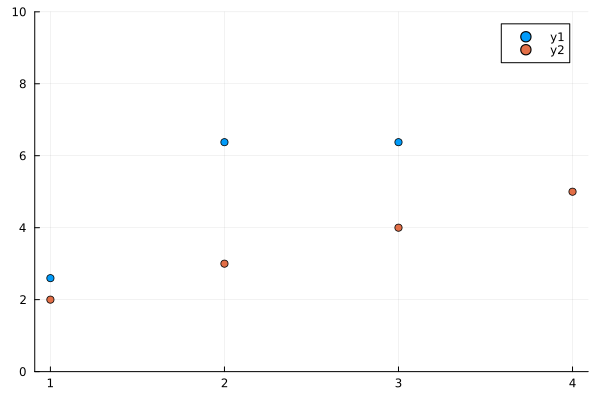

In [33]:
nvector=[i for i in eachindex(ϵ)]
scatter(nvector,real(ϵ),ylims=(0,10))
scatter!(nvector,ϵ_real)